In [113]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.integrate import odeint
from scipy import optimize

In [125]:
filename = (input("File in Log Rocket Data? (Without .txt)?: ")) #"38mm9(0.15625C)_apend_10.0%"
Dt= float(input('Throat Diameter(m)?:')) #0.00396875 
propellant_mass_g = float(input('Propellant Mass (g)?:')) #174.0 #

prefix = "/Users/augustzentner/Downloads/RocketTestStand-main/Log Rocket Data/"
suffix = ".TXT"

filename = prefix + filename + suffix

print(' Using file : ',filename)

time, thrust = np.loadtxt(filename, delimiter=',', unpack=True)


File in Log Rocket Data? (Without .txt)?:  38mm9(0.15625C)_apend_10.0%
Throat Diameter(m)?: 0.00396875 
Propellant Mass (g)?: 174.0


 Using file :  /Users/augustzentner/Downloads/RocketTestStand-main/Log Rocket Data/38mm9(0.15625C)_apend_10.0%.TXT


In [126]:
def area_from_pressure(p1,At):

    pt= pRt*p1
    
    C1= ((k+1.0)/2.0)**(1.0/(k-1.0))
    C2= ((pa/p1)**(1.0/k))
    C3= np.sqrt( ((k+1.0)/(k-1.0))*(1.0-((pa/p1)**((k-1.0)/k))) )
    C4= C1*C2*C3
    Ae = At/C4
    
    De = np.sqrt((Ae/np.pi))
    De_cm = De *100

    ER= Ae/At

    return Ae, ER

In [127]:
def area_exit(pe, p1, At, Aet):

    pt= pRt*p1
    
    C1= ((k+1.0)/2.0)**(1.0/(k-1.0))
    C2= ((pe/p1)**(1.0/k))
    C3= np.sqrt( ((k+1.0)/(k-1.0))*(1.0-((pe/p1)**((k-1.0)/k))) )
    C4= C1*C2*C3
    
    func_zero = C4 - (At/Aet)
    
    De = np.sqrt((Aet/np.pi))
    De_cm = De *100

    return func_zero

In [128]:
#Dt= float(input('Throat Diameter(m)?:')) #0.00396875 

pa = 101325.0

At = np.pi*((Dt/2.0)**2)

pRt= 0.5772057472 # relative pressure

k = 1.1361 # some property of the fuel

k2= 1.0423 # some comment here

R = 228.4

#propellant_mass_g = float(input('Propellant Mass (g)?:')) #174.0 #
propellant_mass = propellant_mass_g * 0.001

t_initial = np.min(time)
t_final = np.max(time)

n_step_max=10000

interp_func_th = interp1d(time, thrust)

[total_impulse_2,impulse_error] = integrate.quad(interp_func_th,t_initial,t_final,limit=n_step_max)
mass_derivative_constant = (1.0/(propellant_mass)) * total_impulse_2

dmdt = interp_func_th(time)/mass_derivative_constant

interp_func_dmdt = interp1d(time, dmdt)

factor1 = 2.0*(k2**2)/(k2-1.0)
factor2 = (2.0/(k2+1.0))**((k2+1.0)/(k2-1.0))
factor3 = (1.0-(pRt**((k2-1.0)/k2)))

C5 = np.sqrt(factor1*factor2*factor3) + pRt

p1 = (thrust/At + pa)/C5
pt= pRt *p1

vt = (thrust - (pt - pa)*At)/dmdt

interp_func_vt = interp1d(time, vt)

max_p1 = np.max(p1)
min_p1 = np.min(p1)

Ae_max, Er_max = area_from_pressure(max_p1, At)
Ae_min, Er_min = area_from_pressure(min_p1, At)

Ae_test_lst = np.linspace(Ae_min, Ae_max, 50)


/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/301377788.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  [total_impulse_2,impulse_error] = integrate.quad(interp_func_th,t_initial,t_final,limit=n_step_max)


In [129]:
def calc_isp(Aet, Dt, pa, At, pRt, k, k2, R, t_initial, t_final, n_step_max, interp_func_th, dmdt, interp_func_dmdt, p1, pt, vt):
    # area_exit(pe, p1, At, Aet)

    pevals = ([])
    n=0
    
    for pressure in p1:
        
        extra_args = (pressure, At, Aet)
    
        p1zero = optimize.brentq( area_exit, 0.001, pt[n], args=extra_args )
        
        pevals = np.append(pevals, p1zero) # convert from ratio to true pe
        
        n=n+1

    pe = pevals

    pRe = (pe/p1)
    
    f1 = (k+1.0)/(k-1.0)
    pwr = (k-1.0)/k
    f2 = (1.0 - ((pRe)**pwr))
    
    ve = vt*np.sqrt(f1*f2)
    
    thrust_f1= dmdt*ve
    thrust_f2= (pe-pa)*(Aet)
    Exit_thrust= thrust_f1+ thrust_f2

    
    Isp_f1 = (Exit_thrust/dmdt)
    Isp = Isp_f1/9.81
    
    interp_func_th2 = interp1d(time, Exit_thrust)
    Impulse2, error= integrate.quad(interp_func_th2, t_initial, t_final, limit=n_step_max)
    
    m2, error= integrate.quad(interp_func_dmdt, t_initial, t_final, limit=n_step_max)
    dmdt_avg = m2/t_final

    F_avg = Impulse2/t_final
    IspF = ((F_avg/dmdt_avg)/9.81)
    
    
    
    return IspF

/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/1277579954.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Impulse2, error= integrate.quad(interp_func_th2, t_initial, t_final, limit=n_step_max)
/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/1277579954.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  m2, error= integrate.quad(interp_func_dmdt, t_initial, t_final, limit=n_step_max)


[134.03334092 135.34728083 136.47676354 137.45654722 138.31263589
 139.0649613  139.72911609 140.3175134  140.84018568 141.30534923
 141.71981189 142.08927325 142.41854958 142.71174482 142.9723825
 143.2035087  143.40777332 143.58749496 143.74471309 143.88123051
 143.99864801 144.09839305 144.18174352 144.2498476  144.30374051
 144.34435859 144.37255135 144.38909168 144.3946847  144.38997528
 144.37555465 144.35196608 144.31970986 144.27924764 144.23100623
 144.17538099 144.11273881 144.04342068 143.9677441  143.88600511
 143.79848016 143.70542779 143.60709011 143.50369413 143.395453
 143.28256706 143.16522487 143.04360405 142.91787215 142.78818737]


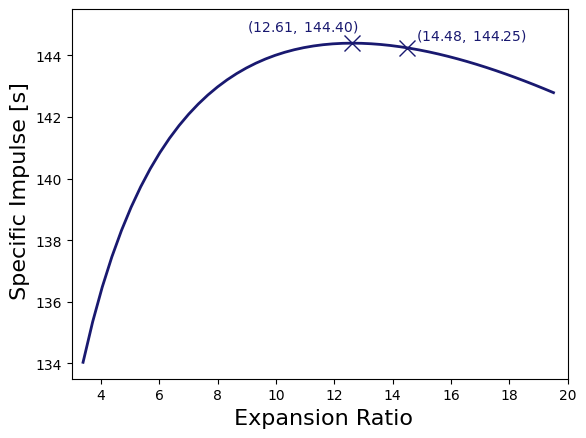

In [151]:
Isp_lst = ([])

for Ae in Ae_test_lst:
    Isp = calc_isp(Ae, Dt, pa, At, pRt, k, k2, R, t_initial, t_final, n_step_max, interp_func_th, dmdt, interp_func_dmdt, p1, pt, vt)
    Isp_lst = np.append(Isp_lst, Isp)

print(Isp_lst)

ER_lst = Ae_test_lst/ At

fig = plt.figure()

plt.plot(ER_lst,Isp_lst,linewidth=2.0,color='midnightblue')

#12.61044718, 144.39469026869833
#14.48, 144.24563007587508

plt.plot([12.61045],[144.3947],marker='x',markersize=12,linewidth=3.0,color='midnightblue')
plt.plot([14.48],[144.24563],marker='x',markersize=12,linewidth=3.0,color='midnightblue')

plt.text(9.00,144.8,r"$(12.61,\ 144.40)$",color='midnightblue')
plt.text(14.8,144.5,r"$(14.48,\ 144.25)$",color='midnightblue')

plt.xlim(3.0,20.0)
plt.ylim(133.5,145.5)

plt.xlabel(' Expansion Ratio',fontsize=16)
plt.ylabel(' Specific Impulse [s]',fontsize=16)

plt.show()

In [131]:
def neg_calc_isp(Aet, Dt, pa, At, pRt, k, k2, R, t_initial, t_final, n_step_max, interp_func_th, dmdt, interp_func_dmdt, p1, pt, vt):
    Neg_Isp = -1*calc_isp(Aet, Dt, pa, At, pRt, k, k2, R, t_initial, t_final, n_step_max, interp_func_th, dmdt, interp_func_dmdt, p1, pt, vt)
    return Neg_Isp

In [132]:
Isp_lst = ([])

args2= (Dt, pa, At, pRt, k, k2, R, t_initial, t_final, n_step_max, interp_func_th, dmdt, interp_func_dmdt, p1, pt, vt)

res = optimize.minimize(neg_calc_isp,x0 = (1.05* Ae_test_lst[0]) ,args=args2)

Ae_O = res.x

Isp_O = calc_isp(Ae_O, Dt, pa, At, pRt, k, k2, R, t_initial, t_final, n_step_max, interp_func_th, dmdt, interp_func_dmdt, p1, pt, vt)

De_O = 2* np.sqrt((Ae_O/np.pi))

print(Ae_O)
print(Isp_O)

/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/1277579954.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Impulse2, error= integrate.quad(interp_func_th2, t_initial, t_final, limit=n_step_max)
/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/1277579954.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  m2, error= integrate.quad(interp_func_dmdt, t_initial, t_final, limit=n_step_max)
/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/1277579954.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Impulse2, error= integrate.quad(interp_func_th2, t_initial, t_final, limit=n_s

[0.000156]
144.39469026869833


/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/1277579954.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Impulse2, error= integrate.quad(interp_func_th2, t_initial, t_final, limit=n_step_max)
/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/1277579954.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  m2, error= integrate.quad(interp_func_dmdt, t_initial, t_final, limit=n_step_max)


In [133]:
print('Area throat (m**2)', At)
print('Diameter throat (m)', Dt)
print('Area exit (m**2)', Ae_O)
print('Diameter exit (m)', De_O)
print('Expansion Ratio', (Ae_O/At))

Area throat (m**2) 1.2370788063903754e-05
Diameter throat (m) 0.00396875
Area exit (m**2) [0.000156]
Diameter exit (m) [0.0140935]
Expansion Ratio [12.61044718]


In [138]:
Isp_1 = calc_isp(0.000179129, Dt, pa, At, pRt, k, k2, R, t_initial, t_final, n_step_max, interp_func_th, dmdt, interp_func_dmdt, p1, pt, vt)
print(Isp_1)

144.24563007587508


/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/1277579954.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Impulse2, error= integrate.quad(interp_func_th2, t_initial, t_final, limit=n_step_max)
/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/1277579954.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  m2, error= integrate.quad(interp_func_dmdt, t_initial, t_final, limit=n_step_max)


In [135]:

Impulse, error= integrate.quad(interp_func_th, t_initial, t_final, limit=n_step_max)
    
m2, error= integrate.quad(interp_func_dmdt, t_initial, t_final, limit=n_step_max)
dmdt_avg = m2/t_final

F_avg = Impulse/t_final
IspF = ((F_avg/dmdt_avg)/9.81)

print(IspF)
    

106.05662275704674


/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/263918855.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Impulse, error= integrate.quad(interp_func_th, t_initial, t_final, limit=n_step_max)
/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_87310/263918855.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  m2, error= integrate.quad(interp_func_dmdt, t_initial, t_final, limit=n_step_max)
